In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from PIL import Image
import random

# Keras 3 imports
import keras
from keras import layers, models, optimizers, callbacks
from keras.utils import to_categorical
import keras.ops as ops


In [2]:
random.seed(42)
np.random.seed(42)
keras.utils.set_random_seed(42)

In [3]:
IMAGE_SIZE = 224  # Changed from 64 to 224
NUM_CLASSES = 6
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 50
DATASET_PATH = r"/content/drive/MyDrive/concave"

In [5]:
print("--=" * 60)
print("DRDO--" * 10)
print("Convolution and Attention nerual network")
print("DRDO--" * 10)
print("--=" * 60)

--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=
DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--
Convolution and Attention nerual network
DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--DRDO--
--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        print(f"val_loss, best_loss: {val_loss}, {self.best_loss}")
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def load_image_dataset(dataset_path, image_size=IMAGE_SIZE):
    """Load images from directory structure"""
    images = []
    labels = []
    class_names = []

    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return np.array([]), np.array([]), []

    class_dirs = [d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))]
    class_dirs.sort()
    class_names = class_dirs[:NUM_CLASSES]

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        print(f"Loading {len(image_files)} images from class '{class_name}'")

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            try:
                image = Image.open(image_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                image = image.resize((image_size, image_size))
                image_array = np.array(image) / 255.0

                images.append(image_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")

    return np.array(images), np.array(labels), class_names

In [7]:
class SqueezeExciteBlock(layers.Layer):
    def __init__(self, channels, reduction=4, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction
        self.gap = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(channels // reduction, activation='gelu')
        self.dense2 = layers.Dense(channels, activation='sigmoid')
        self.reshape = layers.Reshape((1, 1, channels))
        self.multiply = layers.Multiply()

    def call(self, inputs):
        se = self.gap(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape(se)
        return self.multiply([inputs, se])

    def get_config(self):
        config = super().get_config()
        config.update({
            'channels': self.channels,
            'reduction': self.reduction
        })
        return config

In [8]:
class MBConvBlock(layers.Layer):
    def __init__(self, in_channels, out_channels, expansion_factor=4, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.expansion_factor = expansion_factor
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)

        expanded_channels = in_channels * expansion_factor

        # Batch norm and activation
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation('gelu')

        # Expansion (if needed)
        if expansion_factor != 1:
            self.expand_conv = layers.Conv2D(
                expanded_channels, 1, padding='same', use_bias=False
            )
            self.expand_bn = layers.BatchNormalization()
            self.expand_act = layers.Activation('gelu')
        else:
            self.expand_conv = None

        # Depthwise convolution
        self.dw_conv = layers.DepthwiseConv2D(
            3, strides=stride, padding='same', use_bias=False
        )
        self.dw_bn = layers.BatchNormalization()
        self.dw_act = layers.Activation('gelu')

        # Squeeze and Excitation
        self.se = SqueezeExciteBlock(expanded_channels)

        # Projection
        self.project_conv = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)
        self.project_bn = layers.BatchNormalization()

        # Residual connection adjustment
        if self.use_residual and in_channels != out_channels:
            self.residual_conv = layers.Conv2D(out_channels, 1, use_bias=False)
        else:
            self.residual_conv = None

    def call(self, inputs):
        x = inputs
        residual = inputs

        # Batch norm and activation
        x = self.bn1(x)
        x = self.act1(x)

        # Expansion
        if self.expand_conv is not None:
            x = self.expand_conv(x)
            x = self.expand_bn(x)
            x = self.expand_act(x)

        # Depthwise convolution
        x = self.dw_conv(x)
        x = self.dw_bn(x)
        x = self.dw_act(x)

        # Squeeze and Excitation
        x = self.se(x)

        # Projection
        x = self.project_conv(x)
        x = self.project_bn(x)

        # Residual connection
        if self.use_residual:
            if self.residual_conv is not None:
                residual = self.residual_conv(residual)
            x = layers.Add()([residual, x])

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'expansion_factor': self.expansion_factor,
            'stride': self.stride
        })
        return config

In [9]:
class SelfAttention2D(layers.Layer):
    def __init__(self, in_channels, out_channels, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.head_dim = out_channels // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = layers.Conv2D(out_channels * 3, 1, use_bias=False)
        self.proj = layers.Conv2D(out_channels, 1)
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        B, H, W, C = ops.shape(inputs)

        # Generate Q, K, V
        qkv = self.qkv(inputs)
        qkv = ops.reshape(qkv, (B, H * W, 3, self.num_heads, self.head_dim))
        qkv = ops.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention computation
        attn = ops.matmul(q, ops.transpose(k, (0, 1, 3, 2))) * self.scale
        attn = ops.softmax(attn, axis=-1)

        # Apply attention to values
        out = ops.matmul(attn, v)
        out = ops.transpose(out, (0, 2, 1, 3))
        out = ops.reshape(out, (B, H, W, self.out_channels))

        # Final projection
        out = self.proj(out)
        out = self.dropout(out)

        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'num_heads': self.num_heads
        })
        return config

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, in_channels, out_channels, num_heads=8, stride=1, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)

        # Layer normalization
        self.ln1 = layers.LayerNormalization()

        # Stride handling
        if stride > 1:
            self.downsample = layers.MaxPooling2D(stride)
        else:
            self.downsample = None

        # Self attention
        self.attn = SelfAttention2D(in_channels, out_channels, num_heads)

        # Feed forward network
        self.ln2 = layers.LayerNormalization()
        self.mlp = keras.Sequential([
            layers.Conv2D(out_channels * 4, 1, activation='gelu'),
            layers.Dropout(dropout),
            layers.Conv2D(out_channels, 1),
            layers.Dropout(dropout)
        ])

        # Residual connection adjustment
        if in_channels != out_channels:
            self.residual_conv = layers.Conv2D(out_channels, 1, use_bias=False)
        else:
            self.residual_conv = None

    def call(self, inputs):
        residual = inputs

        # Apply stride if needed
        if self.downsample is not None:
            inputs = self.downsample(inputs)
            residual = self.downsample(residual)

        # Self attention
        x = self.ln1(inputs)
        x = self.attn(x)

        # Residual connection for attention
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        if self.use_residual or self.residual_conv is not None:
            x = layers.Add()([residual, x])

        # Feed forward
        residual = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = layers.Add()([residual, x])

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'num_heads': self.num_heads,
            'stride': self.stride
        })
        return config


In [11]:
def create_coatnet_model(num_classes, image_size, dropout_rate=0.3):
    """Create CoAtNet model - MODIFIED for 224x224"""
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Data augmentation (only during training)
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomContrast(0.1)(x)

    # Stem (Initial convolution) - Modified for 224x224
    x = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False)(x)  # 224->112
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)  # 112x112
    x = layers.BatchNormalization()(x)

    # Stage 0: Additional MBConv blocks for better feature extraction
    x = MBConvBlock(64, 96, expansion_factor=4, stride=1)(x)  # 112x112x96
    x = MBConvBlock(96, 96, expansion_factor=4, stride=1)(x)  # 112x112x96

    # Stage 1: MBConv blocks (S1)
    x = MBConvBlock(96, 96, expansion_factor=4, stride=2)(x)  # 112->56
    x = MBConvBlock(96, 96, expansion_factor=4, stride=1)(x)  # 56x56x96
    x = MBConvBlock(96, 96, expansion_factor=4, stride=1)(x)  # 56x56x96

    # Stage 2: MBConv blocks with stride (S2)
    x = MBConvBlock(96, 128, expansion_factor=4, stride=2)(x)  # 56->28
    x = MBConvBlock(128, 128, expansion_factor=4, stride=1)(x)  # 28x28x128
    x = MBConvBlock(128, 128, expansion_factor=4, stride=1)(x)  # 28x28x128

    # Stage 3: Transformer blocks (S3)
    x = TransformerBlock(128, 256, num_heads=8, stride=2)(x)  # 28->14
    x = TransformerBlock(256, 256, num_heads=8, stride=1)(x)  # 14x14x256
    x = TransformerBlock(256, 256, num_heads=8, stride=1)(x)  # 14x14x256

    # Stage 4: Final transformer blocks (S4)
    x = TransformerBlock(256, 512, num_heads=8, stride=2)(x)  # 14->7
    x = TransformerBlock(512, 512, num_heads=8, stride=1)(x)  # 7x7x512
    x = TransformerBlock(512, 512, num_heads=8, stride=1)(x)  # 7x7x512

    # Classification head
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [12]:
def create_simple_model(num_classes, image_size):
    """Alternative simpler model if CoAtNet is too complex - MODIFIED for 224x224"""
    model = models.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),

        # Augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

        # Feature extraction - Modified for 224x224
        layers.Conv2D(32, 3, strides=2, activation='relu'),  # 224->112
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),  # 112->56

        layers.Conv2D(64, 3, activation='relu'),  # 56x56
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),  # 56->28

        layers.Conv2D(128, 3, activation='relu'),  # 28x28
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),  # 28->14

        layers.Conv2D(256, 3, activation='relu'),  # 14x14
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),  # 14->7

        layers.Conv2D(512, 3, activation='relu'),  # 7x7
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Classification head
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [13]:
def train_model(model, train_data, val_data, class_names):
    """Train the model with early stopping"""

    # Compile model
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=45,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    )

    model_checkpoint = callbacks.ModelCheckpoint(
        'best_coatnet_model.keras',
        monitor='val_loss',
        save_best_only=True
    )

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    return history

In [14]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [15]:
def evaluate_model(model, test_data, class_names):
    """Evaluate model and create confusion matrix"""

    # Get predictions
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = []
    for _, labels in test_data:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, cm

Loading dataset...
Found 899 files belonging to 6 classes.
Using 720 files for training.
Found 899 files belonging to 6 classes.
Using 179 files for validation.
Found 6 classes: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']
Creating CoAtNet model...
CoAtNet model created successfully!
Starting training...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block (MBConvBlock)     │ (None, 112, 112, 96)   │        79,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_1 (MBConvBlock)   │ (None, 112, 112, 96)   │       155,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_2 (MBConvBlock)   │ (None, 56, 56, 96)     │       155,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_3 (MBConvBlock)   │ (None, 56, 56, 96)     │       155,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_4 (MBConvBlock)   │ (None, 56, 56, 96)     │       155,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_5 (MBConvBlock)   │ (None, 28, 28, 128)    │       167,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_6 (MBConvBlock)   │ (None, 28, 28, 128)    │       272,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_block_7 (MBConvBlock)   │ (None, 28, 28, 128)    │       272,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 14, 14, 256)    │       723,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 14, 14, 256)    │       788,992 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 14, 14, 256)    │       788,992 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,946,918 (49.39 MB)

 Trainable params: 12,930,534 (49.33 MB)

 Non-trainable params: 16,384 (64.00 KB)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.1719 - loss: 3.5313 - val_accuracy: 0.1508 - val_loss: 2.1812 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2943 - loss: 1.7983 - val_accuracy: 0.1788 - val_loss: 2.8101 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3375 - loss: 1.6991 - val_accuracy: 0.1788 - val_loss: 4.3025 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3613 - loss: 1.6079 - val_accuracy: 0.1788 - val_loss: 4.6907 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4219 - loss: 1.4536 - val_accuracy: 0.1788 - val_loss: 4.1900 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4732 - loss: 1.3181 - val_accuracy: 0.1788 - val_loss: 5.7422 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5271 - loss

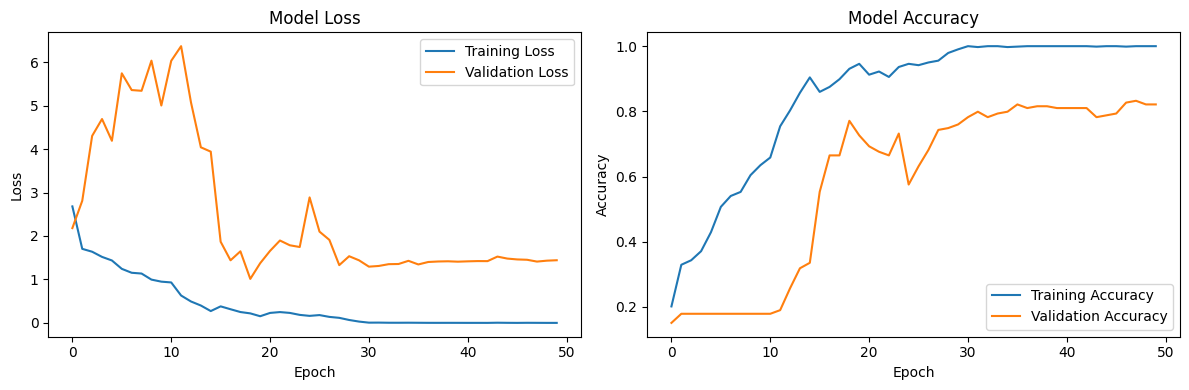

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step
Test Accuracy: 0.7709

Classification Report:
                         precision    recall  f1-score   support

         Moon_jellyfish       0.85      0.88      0.86        32
       barrel_jellyfish       0.76      0.86      0.81        29
         blue_jellyfish       0.58      0.62      0.60        24
      compass_jellyfish       0.84      0.84      0.84        38
   lions_mane_jellyfish       0.83      0.66      0.73        29
mauve_stinger_jellyfish       0.73      0.70      0.72        27

               accuracy                           0.77       179
              macro avg       0.76      0.76      0.76       179
           weighted avg       0.77      0.77      0.77       179



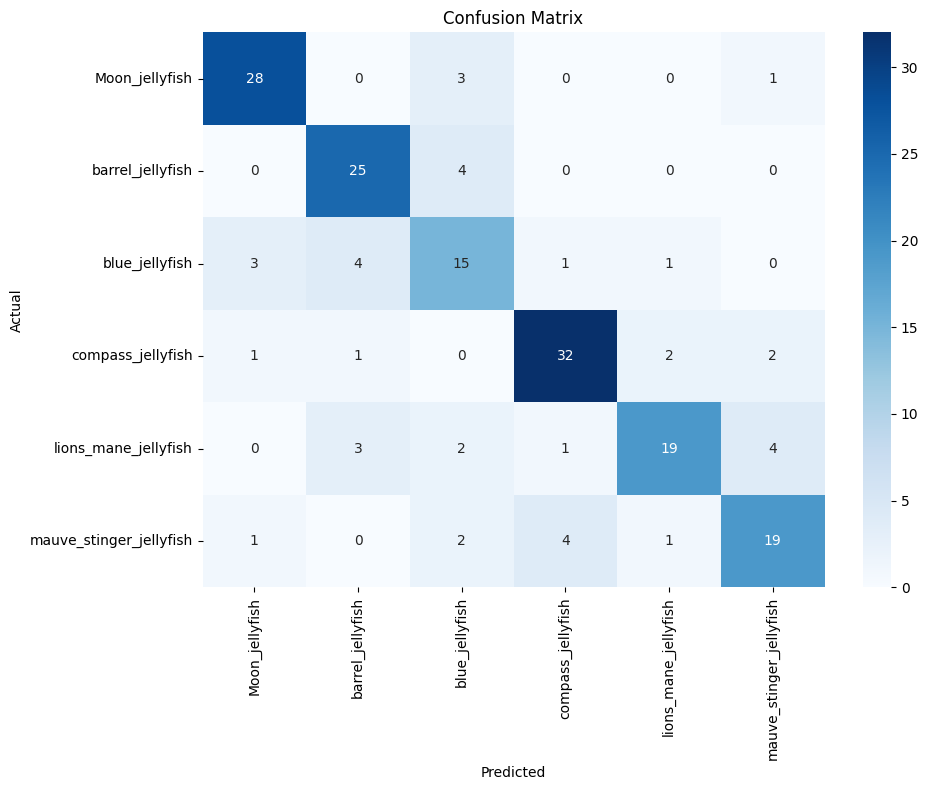

Training completed!


In [16]:
def main():
    """Main training pipeline"""
    print("Loading dataset...")

    # Check if dataset path exists
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset path {DATASET_PATH} does not exist!")
        print("Please make sure your images are organized in subdirectories by class.")
        return

    # Create data generators directly
    try:
        train_dataset = keras.utils.image_dataset_from_directory(
            DATASET_PATH,
            validation_split=0.2,
            subset="training",
            seed=42,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='int'
        )

        val_dataset = keras.utils.image_dataset_from_directory(
            DATASET_PATH,
            validation_split=0.2,
            subset="validation",
            seed=42,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='int'
        )

        # Get class names
        class_names = train_dataset.class_names
        NUM_CLASSES = len(class_names)

        print(f"Found {NUM_CLASSES} classes: {class_names}")

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Make sure your dataset directory contains subdirectories for each class.")
        return

    # Normalize data
    normalization_layer = layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Optimize performance
    AUTOTUNE = -1  # Use -1 for auto-tuning in Keras 3
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Create model
    print("Creating CoAtNet model...")
    try:
        model = create_coatnet_model(NUM_CLASSES, IMAGE_SIZE)
        print("CoAtNet model created successfully!")
    except Exception as e:
        print(f"Error creating CoAtNet model: {e}")
        print("Using simpler model...")
        model = create_simple_model(NUM_CLASSES, IMAGE_SIZE)

    # Train model
    print("Starting training...")
    history = train_model(model, train_dataset, val_dataset, class_names)

    # Plot results
    plot_training_history(history)

    # Evaluate model
    print("Evaluating model...")
    accuracy, cm = evaluate_model(model, val_dataset, class_names)

    # Save metrics
    metrics_df = pd.DataFrame({
        'epoch': range(len(history.history['loss'])),
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy']
    })
    metrics_df.to_csv('training_metrics.csv', index=False)

    print("Training completed!")

if __name__ == "__main__":
    main()